In [1]:
import sys
print(sys.version)

from PIL import Image
from vangogh.evolution import Evolution
from vangogh.fitness import draw_voronoi_image
from vangogh.util import IMAGE_SHRINK_SCALE, REFERENCE_IMAGE
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import ImageGrid
plt.style.use('classic')
%matplotlib inline

from multiprocess import Pool, cpu_count


3.8.10 (default, Nov 22 2023, 10:22:35) 
[GCC 9.4.0]


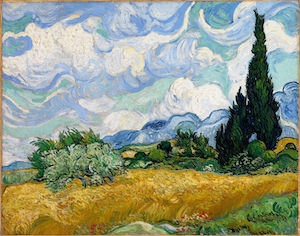

In [2]:
display(REFERENCE_IMAGE)

In [3]:
# Enable to show live rendering of best individual during optimization
display_output = False
# Enable to save progress images at every 50th generation
save_progress = True
# Enable to print verbose output per generation
verbose_output = True

In [4]:
def reporter(time, evo):
    if save_progress or display_output:
        elite = draw_voronoi_image(evo.elite, evo.reference_image.width, evo.reference_image.height, scale=IMAGE_SHRINK_SCALE)
    if display_output:
        clear_output()
        display(elite)
    if save_progress and time["num-generations"] % 50 == 0:
        elite.save(f"./img/van_gogh_intermediate_{evo.seed}_{evo.population_size}_{evo.crossover_method}_{evo.num_points}_{evo.initialization}_{evo.generation_budget}_{time['num-generations']:05d}.png")

def run_algorithm(settings):
    seed, population_size, crossover_method, num_points, initialization, generation_budget = settings
    start = time()
    
    data = []
    evo = Evolution(num_points,
                    REFERENCE_IMAGE,
                    population_size=population_size,
                    generation_reporter=reporter,
                    crossover_method=crossover_method,
                    seed=seed,
                    initialization=initialization,
                    generation_budget=generation_budget,
                    num_features_mutation_strength=.25,
                    selection_name='tournament_4',
                    verbose=verbose_output)
    data = evo.run()
    time_spent = time() - start
    print(f"Done: run {seed} - pop {population_size} - crossover {crossover_method} - num. points {num_points} - initialization {initialization} - in {int(time_spent)} seconds")
    
    return data

## Running a single instance

In [5]:
%%time
data = run_algorithm((0, 200, "RBFNX", 200, 'RANDOM', 500))
df = pd.DataFrame(data)

generation: 1 best fitness: 140837 avg. fitness: 146594.135
generation: 2 best fitness: 140837 avg. fitness: 143400.305
generation: 3 best fitness: 139810 avg. fitness: 141553.375
generation: 4 best fitness: 139174 avg. fitness: 140576.335
generation: 5 best fitness: 138074 avg. fitness: 139950.06
generation: 6 best fitness: 137773 avg. fitness: 139451.655
generation: 7 best fitness: 137767 avg. fitness: 138776.245
generation: 8 best fitness: 136608 avg. fitness: 138224.475
generation: 9 best fitness: 136608 avg. fitness: 137800.39
generation: 10 best fitness: 136592 avg. fitness: 137525.65
generation: 11 best fitness: 136295 avg. fitness: 137147.48
generation: 12 best fitness: 135459 avg. fitness: 136649.115
generation: 13 best fitness: 135459 avg. fitness: 136337.755
generation: 14 best fitness: 135152 avg. fitness: 135988.335
generation: 15 best fitness: 135152 avg. fitness: 135681.435
generation: 16 best fitness: 134825 avg. fitness: 135449.68
generation: 17 best fitness: 134579 av

## Running a sweep of settings

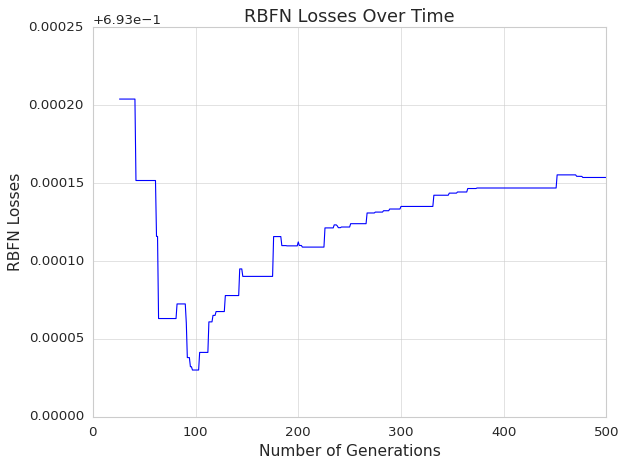

In [6]:
# Plot the first plot
sns.set_style("whitegrid")
custom_palette = sns.color_palette("husl", 3)

# Plot the second plot
plt.figure()  # Create a new figure
sns.lineplot(data=df, x='num-generations', y='rbfn-loss', color='blue')  # Plot the 'rbfn-losses' column
plt.title('RBFN Losses Over Time', fontsize=16)
plt.xlabel('Number of Generations', fontsize=14)
plt.ylabel('RBFN Losses', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [7]:
%%time

generation_budget = 100
 
data = []
for seed in range(1):
    for population_size in (100,):
        for crossover_method in ("ONE_POINT", "TWO_POINT", "UNIFORM", "RBFNX"):
            for initialization in ("RANDOM",):
                for num_points in (500, ):
                    data.extend(run_algorithm((seed, population_size, crossover_method, num_points, initialization, generation_budget)))

generation: 1 best fitness: 143624 avg. fitness: 147507.57
generation: 2 best fitness: 142582 avg. fitness: 145257.81
generation: 3 best fitness: 141228 avg. fitness: 144109.6
generation: 4 best fitness: 138700 avg. fitness: 142691.86
generation: 5 best fitness: 138700 avg. fitness: 141626.23
generation: 6 best fitness: 136554 avg. fitness: 140393.58
generation: 7 best fitness: 136554 avg. fitness: 139369.0
generation: 8 best fitness: 135930 avg. fitness: 138240.7
generation: 9 best fitness: 135286 avg. fitness: 137198.18
generation: 10 best fitness: 135286 avg. fitness: 136402.12
generation: 11 best fitness: 134620 avg. fitness: 135880.65
generation: 12 best fitness: 134498 avg. fitness: 135421.35
generation: 13 best fitness: 134353 avg. fitness: 135054.64
generation: 14 best fitness: 134194 avg. fitness: 134747.52
generation: 15 best fitness: 134158 avg. fitness: 134509.64
generation: 16 best fitness: 133891 avg. fitness: 134329.6
generation: 17 best fitness: 133579 avg. fitness: 134

## Evaluating the results

In [8]:
df = pd.DataFrame(data)
df["time-elapsed"] = df["time-elapsed"].round(0)

/tmp/ipykernel_4133/2134009275.py:4: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df, x='num-generations', y='best-fitness', hue='crossover-method', errorbar=None, palette=custom_palette, style='crossover-method', markers=True, dashes=False)


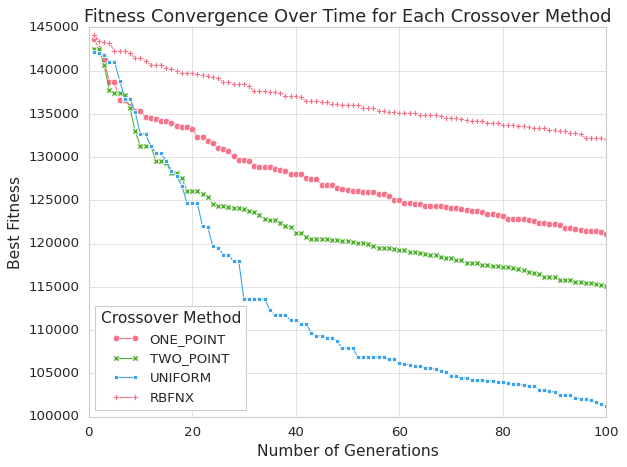

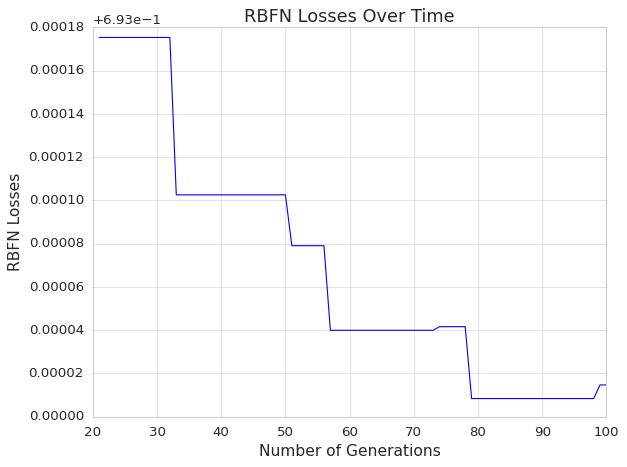

In [9]:

sns.set_style("whitegrid")
custom_palette = sns.color_palette("husl", 3)

sns.lineplot(data=df, x='num-generations', y='best-fitness', hue='crossover-method', errorbar=None, palette=custom_palette, style='crossover-method', markers=True, dashes=False)

plt.title('Fitness Convergence Over Time for Each Crossover Method', fontsize=16)
plt.xlabel('Number of Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Crossover Method', title_fontsize='14', fontsize='12', loc='best')
plt.tight_layout()
plt.show()

plt.figure()
sns.lineplot(data=df, x='num-generations', y='rbfn-loss', color='blue') 
plt.title('RBFN Losses Over Time', fontsize=16)
plt.xlabel('Number of Generations', fontsize=14)
plt.ylabel('RBFN Losses', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Displaying the best instances over time

In [10]:
def show_progress_over_time(settings, selection=None, grid=(5,4)):
    seed, population_size, crossover_method, num_points, initialization, generation_budget = settings
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=grid,
                     axes_pad=0.1,  # pad between axes
                     )

    if selection is None:
        selection = range(50, generation_budget + 50, 50)
    
    img_arr = [Image.open((f"./img/van_gogh_intermediate_{seed}_{population_size}_{crossover_method}_{num_points}_{initialization}_{generation_budget}_{i:05d}.png")) for i in selection]
    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

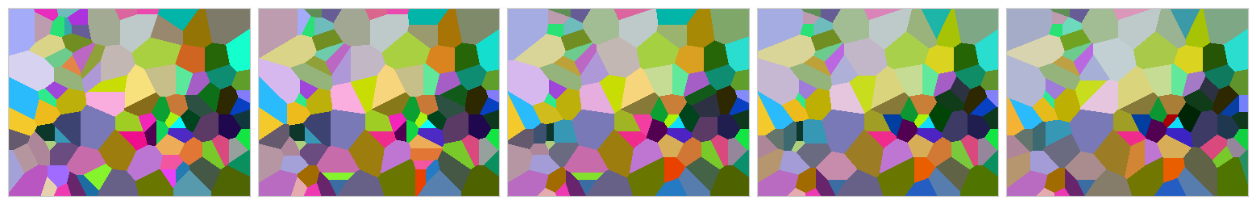

In [11]:
show_progress_over_time((0, 100, 'ONE_POINT', 100, "RANDOM", 500), grid=(1,5))

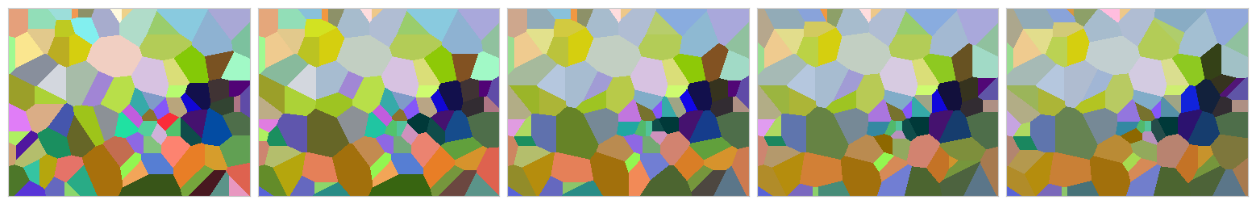

In [12]:
show_progress_over_time((0, 100, 'UNIFORM', 100, "RANDOM", 500), grid=(1,5))

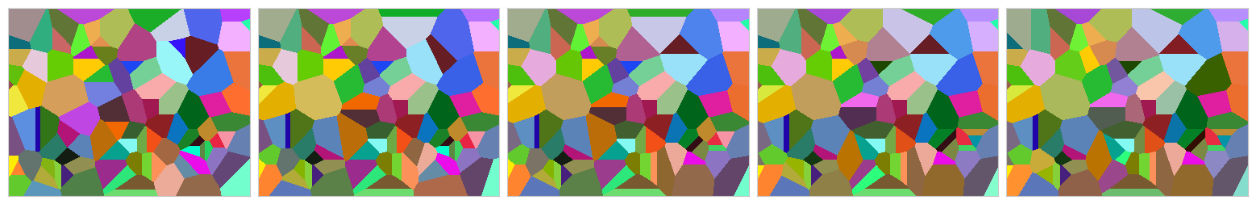

In [13]:
show_progress_over_time((0, 100, 'RBFNX', 100, "RANDOM", 500), grid=(1,5))